In [1]:
from __future__ import print_function

import datetime
import keras
import numpy as np

import os
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.models import  Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping,ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.constraints import maxnorm
from sklearn.cross_validation import StratifiedKFold

from keras import backend as K

from Loaddata_allparttest import load_sampledata,load_sampledata2,load_Harbintestdata
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math


Using TensorFlow backend.


In [2]:
model = load_model('./model/LungEGFR.hdf5')#,weightspatient2-improvement-40-0.67
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 32, 32, 8)    224         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 32, 8)    32          conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 32, 32, 8)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
conv2d_85 

In [3]:
from Loaddata_allparttest import load_sampledata,load_sampledata2,load_Harbintestdata
# xpet_val,xct_val,xfuse_val = load_sampledata()
xpet_val,xct_val,xfuse_val,y = load_Harbintestdata()

xpet_val= np.expand_dims(xpet_val, axis=3)
xct_val = np.expand_dims(xct_val, axis=3)
xfuse_val = np.expand_dims(xfuse_val, axis=3)
x_val = np.concatenate((xpet_val,xct_val,xfuse_val),axis=3)
print(np.shape(x_val))


(2860, 64, 64, 3)


In [4]:
import shap #deeplift 0.19.2
from IntegratedGradients import integrated_gradients ##feature relevance (axiomatic attribution for deep networks)

C:\Users\MuW\AppData\Local\Continuum\Anaconda3\lib\site-packages\shap\explainers\deep.py:10: UserWarning: Your TensorFlow version is older than 1.8.0 and not supported.
  warnings.warn("Your TensorFlow version is older than 1.8.0 and not supported.")
C:\Users\MuW\AppData\Local\Continuum\Anaconda3\lib\site-packages\shap\explainers\deep.py:21: UserWarning: Your Keras version is older than 2.2.0 and not supported.
  warnings.warn("Your Keras version is older than 2.2.0 and not supported.")


In [5]:

ig = integrated_gradients(model)
predict1 = model.predict(x_val, verbose=1)



Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
2860/2860 [==============================] - 6s 2ms/step


(64, 64, 3)


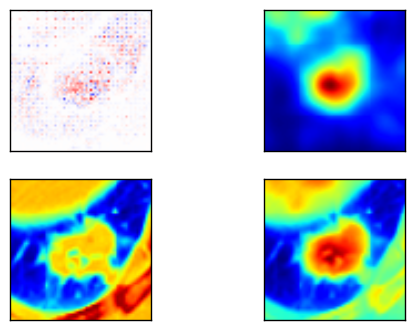

In [8]:
for ind in range(1):
    ind = ind+2848#2834 #
    pred = np.argmax(predict1[ind])
    ex = ig.explain(x_val[ind], outc=pred)
    print(np.shape(ex))
    th = max(np.abs(np.min([np.min(ex), np.min(ex)])), np.abs(np.max([np.max(ex), np.max(ex)])))
    plt.subplot(2, 2, 1)
    plt.imshow(ex[:,:,2], cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    # plt.show()

    plt.subplot(2, 2, 2)
    plt.imshow(xpet_val [ind,:,:,0])
    plt.xticks([],[])
    plt.yticks([],[])
    # plt.show()


    plt.subplot(2, 2, 3)
    plt.imshow(xct_val [ind,:,:,0])
    plt.xticks([],[])
    plt.yticks([],[])
    # plt.show()


    plt.subplot(2, 2, 4)
    plt.imshow(xfuse_val [ind,:,:,0])
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()


[<tf.Tensor 'input_4:0' shape=(?, 64, 64, 3) dtype=float32>]
(1, 2, 64, 64, 3)


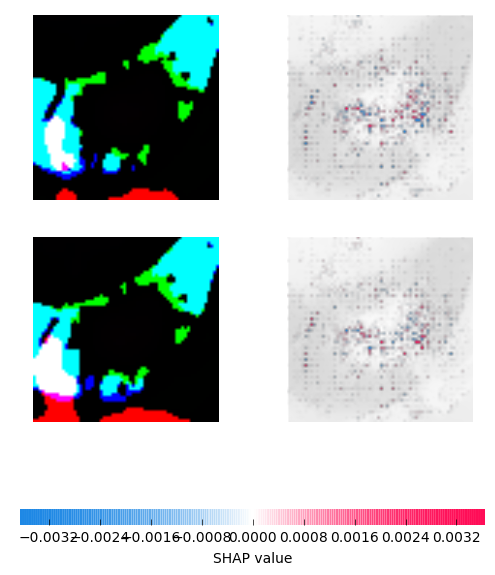

In [9]:
print(model.inputs)
Xtestdif = x_val[2847:2849]#[2434:2439]
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[0].input, model.layers[-1].output),
    map2layer(Xtestdif, 0),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(Xtestdif, 0), ranked_outputs=1)
print(np.shape(shap_values))
shap.image_plot(shap_values, Xtestdif)
# np.save('ttttt.npy', shap_values)

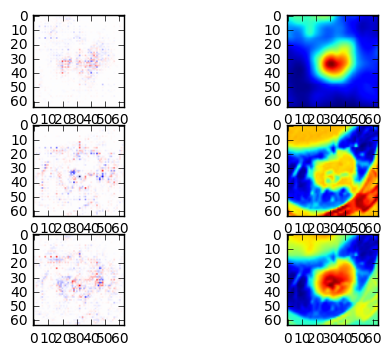

In [10]:
ind=0
th=max(np.abs(np.min(shap_values[ind])), np.abs(np.max(shap_values[ind])))

plt.subplot(3, 2,1)
plt.imshow(shap_values[0][ind][:,:,0], cmap="seismic", vmin=-1*th, vmax=th)

plt.subplot(3, 2,2)
plt.imshow(Xtestdif [ind,:,:,0])

plt.subplot(3, 2,3)
plt.imshow(shap_values[0][ind][:,:,1], cmap="seismic", vmin=-1*th, vmax=th)

plt.subplot(3, 2,4)
plt.imshow(Xtestdif [ind,:,:,1])

plt.subplot(3, 2,5)
plt.imshow(shap_values[0][ind][:,:,2], cmap="seismic", vmin=-1*th, vmax=th)

plt.subplot(3, 2,6)
plt.imshow(Xtestdif [ind,:,:,2])

plt.show()


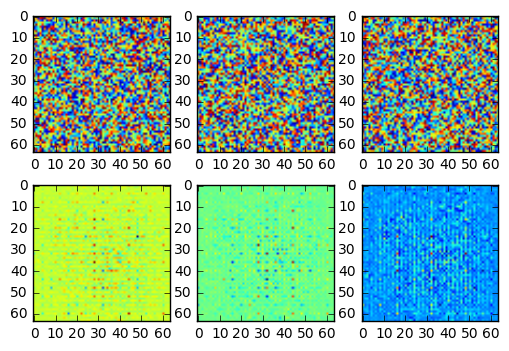

In [11]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'conv2d_106'
for filter_index in range(1):
# filter_index = 2  # can be any integer from 0 to 511, as there are 512 filters in that layer
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.inputs[0])[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.inputs[0]], [loss, grads])  

    input_img_data = np.random.random((1, 64, 64, 3)) 
    plt.subplot(2, 3, 1)
    plt.imshow(input_img_data[0,:,:,0])  
    plt.subplot(2, 3, 2)
    plt.imshow(input_img_data[0,:,:,1])   
    plt.subplot(2, 3, 3)
    plt.imshow(input_img_data[0,:,:,2])   
    
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 1
      

    plt.subplot(2, 3, 4)
    plt.imshow(input_img_data[0,:,:,0])    
    plt.subplot(2, 3, 5)
    plt.imshow(input_img_data[0,:,:,1])    
    plt.subplot(2, 3, 6)
    plt.imshow(input_img_data[0,:,:,2])
    
    plt.grid(False)
    plt.show() 

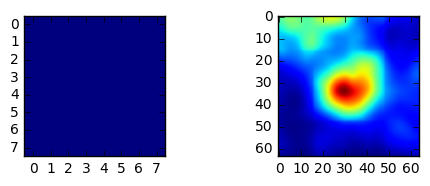

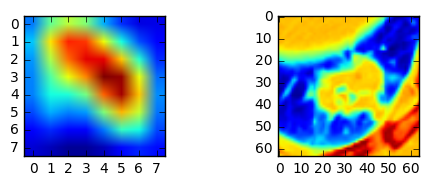

In [26]:
ind = 2848
ggoutput = model.output[:,0]
layer = model.get_layer('activation_76')
grads = K.gradients(ggoutput,layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_val[ind:ind+1,:,:,:]])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
np.save('negfilter2.npy', heatmap)
negheatmap = np.maximum(heatmap, 0)
# negheatmap /= np.max(negheatmap)


ggoutput = model.output[:,1]
grads = K.gradients(ggoutput,layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_val[ind:ind+1,:,:,:]])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
np.save('posfilter2.npy', heatmap)
posheatmap = np.maximum(heatmap, 0)
# posheatmap /= np.max(posheatmap)


th= np.maximum(np.max(negheatmap),np.max(posheatmap))


plt.subplot(2, 2,2)
plt.imshow(xpet_val[ind,:,:,0])
# plt.show()

plt.subplot(2, 2,1)
plt.imshow(negheatmap,vmin=0, vmax=th)
plt.show()

plt.subplot(2, 2,4)
plt.imshow(xct_val[ind,:,:,0])


plt.subplot(2, 2,3)
plt.imshow(posheatmap,vmin=0, vmax=th)
plt.show()     

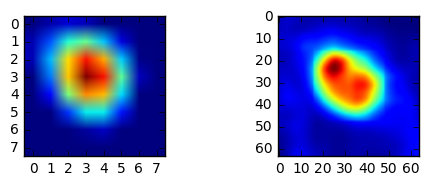

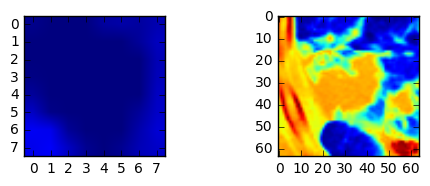

In [25]:
ind = 2433
ggoutput = model.output[:,0]
layer = model.get_layer('activation_76')
grads = K.gradients(ggoutput,layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_val[ind:ind+1,:,:,:]])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
np.save('negfilter1.npy', heatmap)
negheatmap = np.maximum(heatmap, 0)
# negheatmap /= np.max(negheatmap)


ggoutput = model.output[:,1]
grads = K.gradients(ggoutput,layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x_val[ind:ind+1,:,:,:]])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
np.save('posfilter1.npy', heatmap)
posheatmap = np.maximum(heatmap, 0)
# posheatmap /= np.max(posheatmap)


th= np.maximum(np.max(negheatmap),np.max(posheatmap))


plt.subplot(2, 2,2)
plt.imshow(xpet_val[ind,:,:,0])
# plt.show()

plt.subplot(2, 2,1)
plt.imshow(negheatmap,vmin=0, vmax=th)
plt.show()

plt.subplot(2, 2,4)
plt.imshow(xct_val[ind,:,:,0])


plt.subplot(2, 2,3)
plt.imshow(posheatmap,vmin=0, vmax=th)
plt.show()     

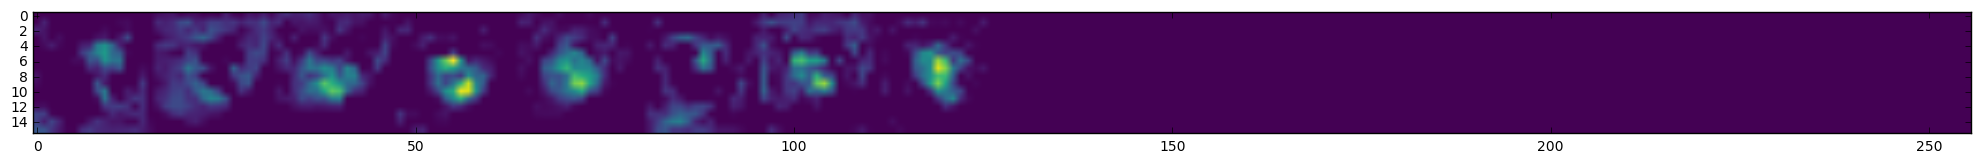

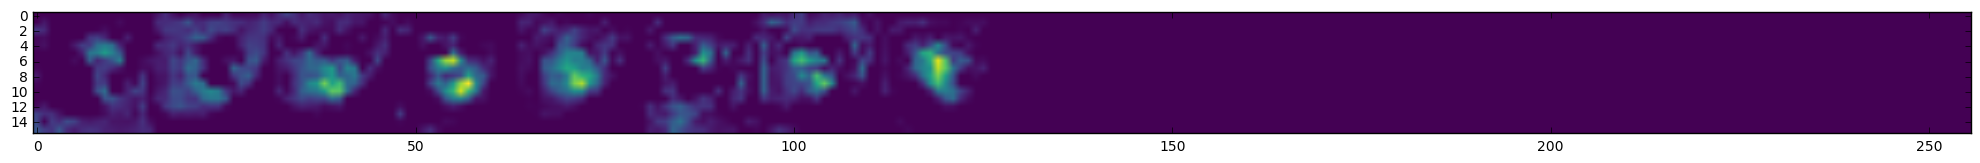

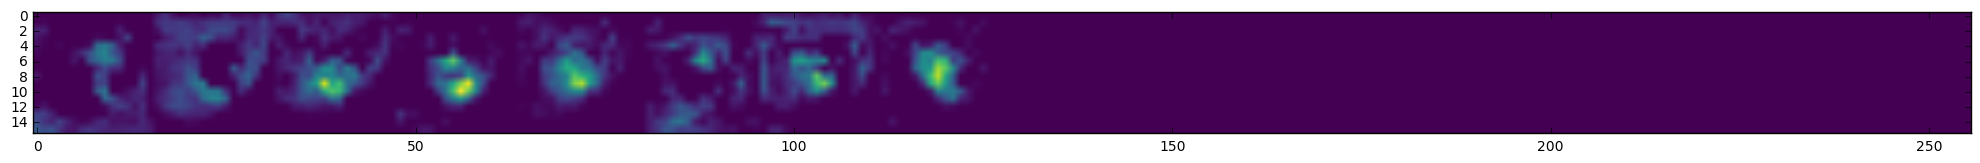

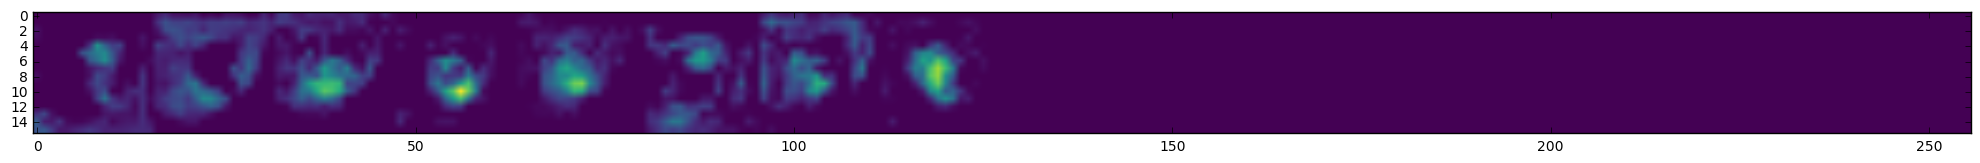

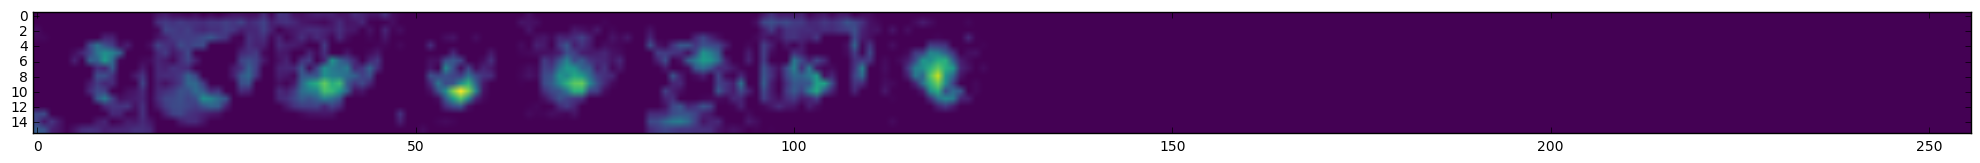

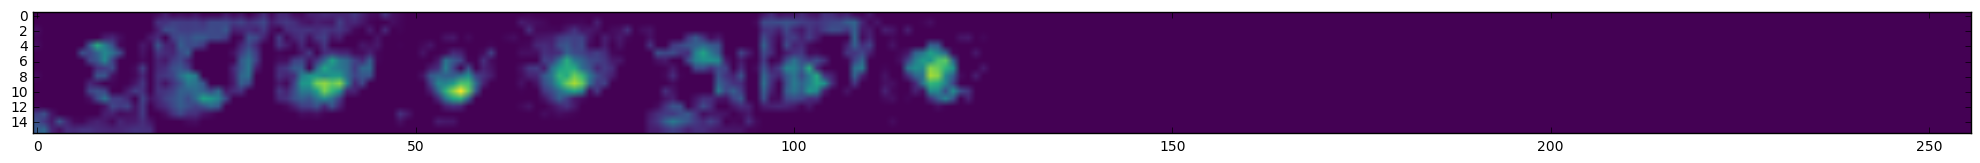

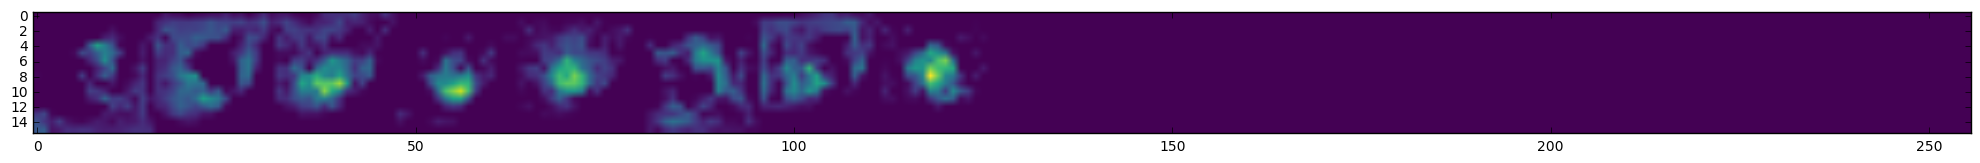

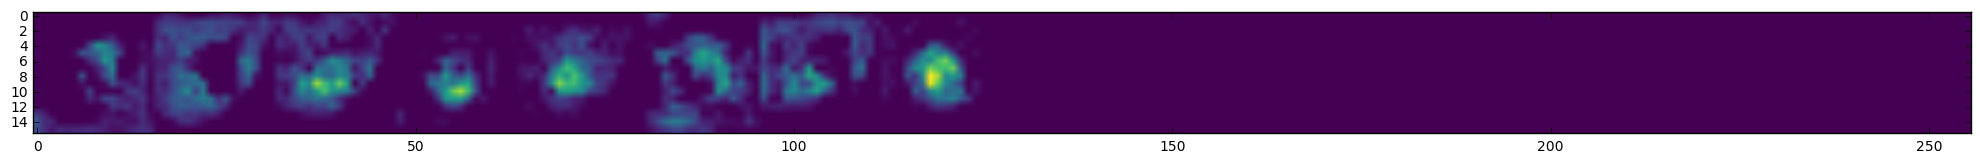

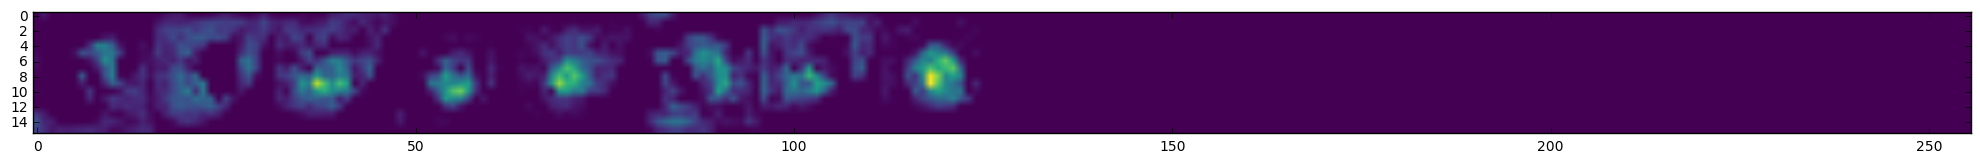

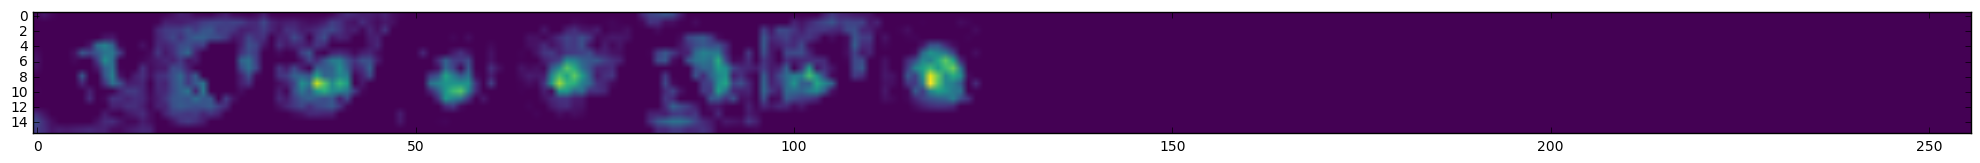

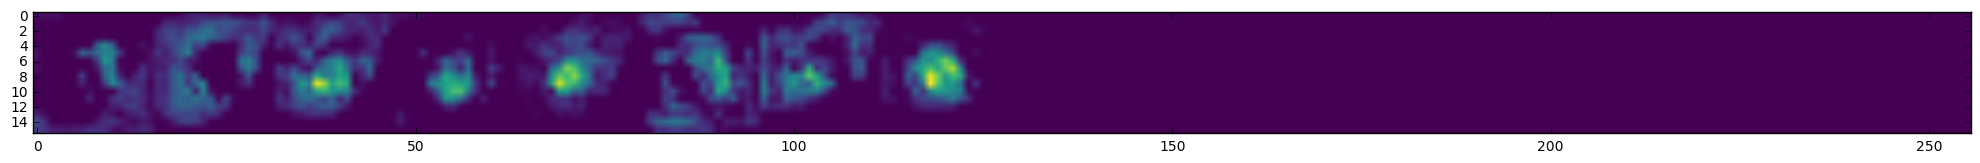

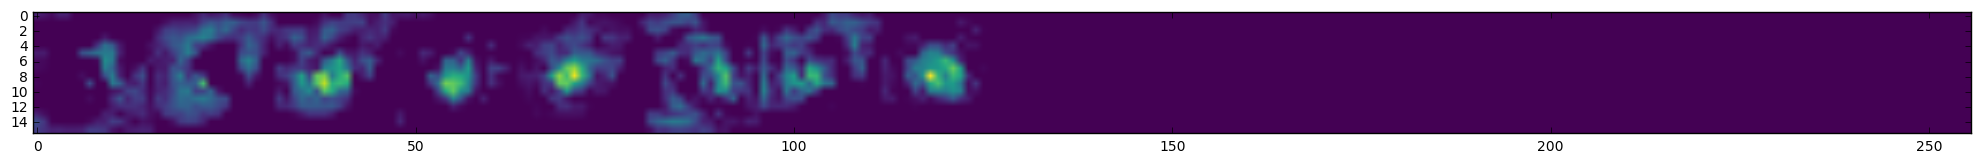

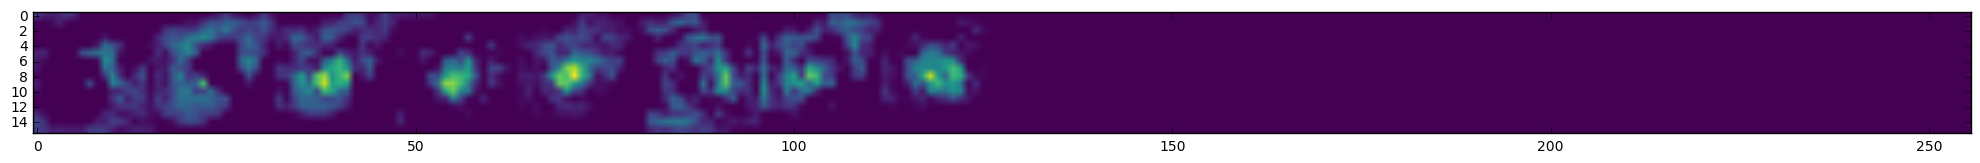

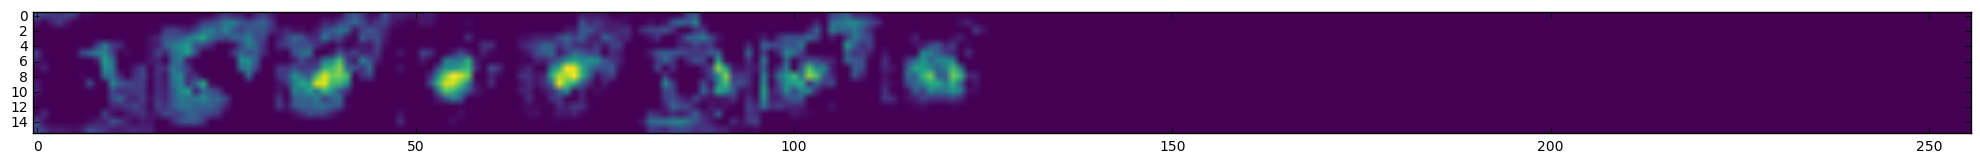

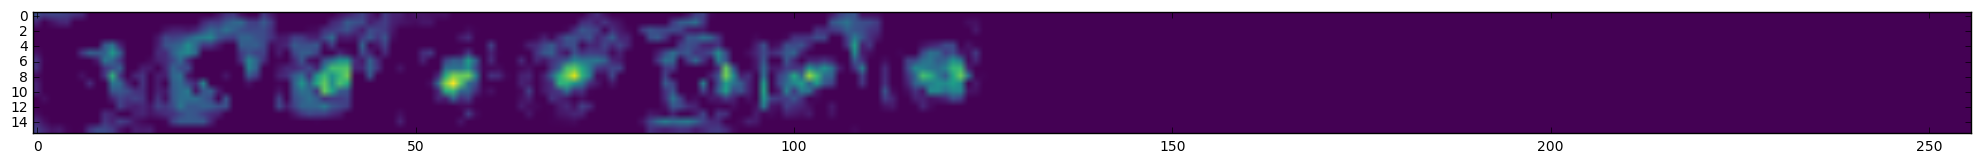

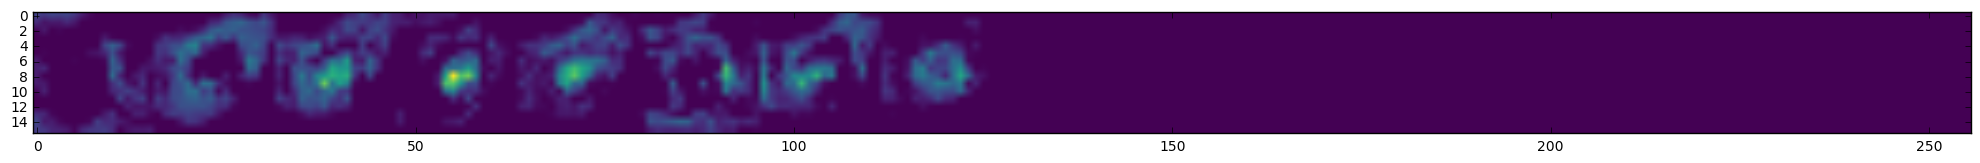

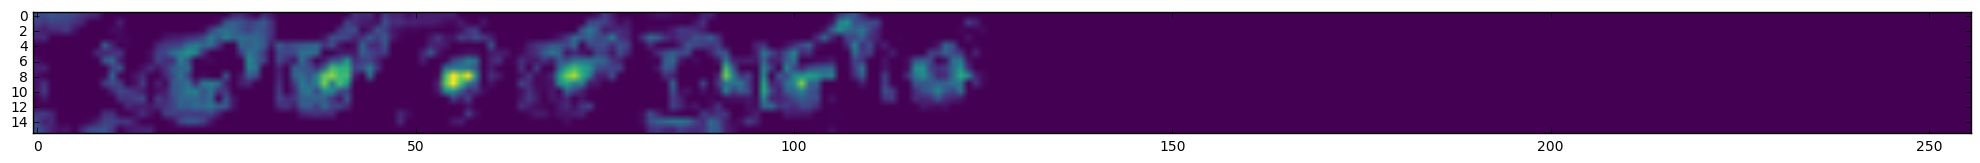

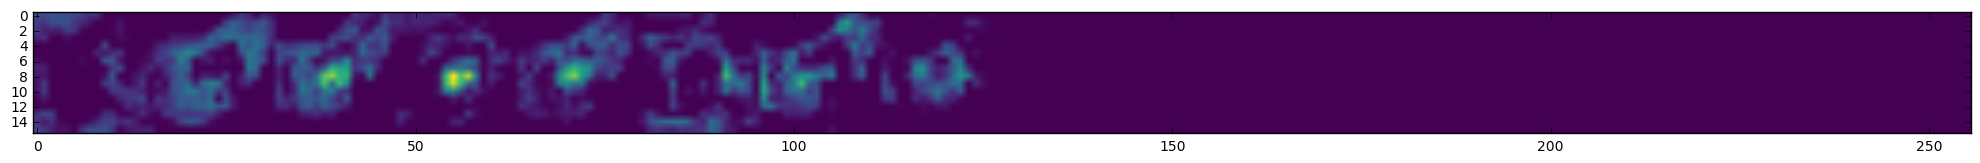

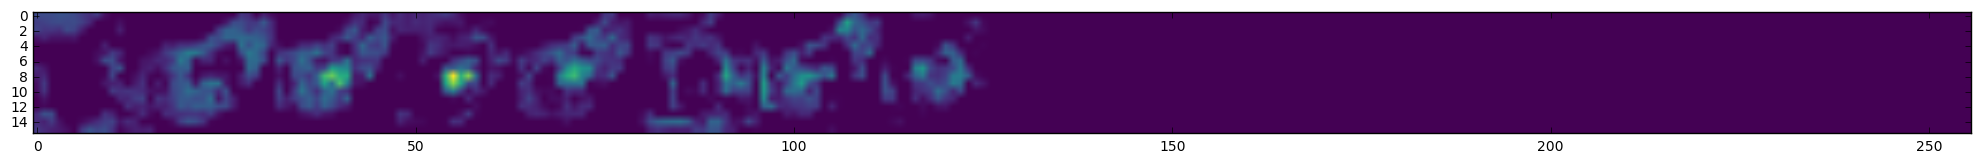

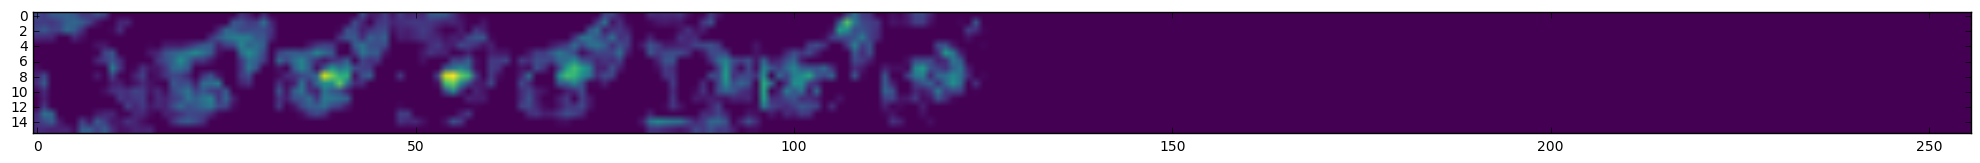

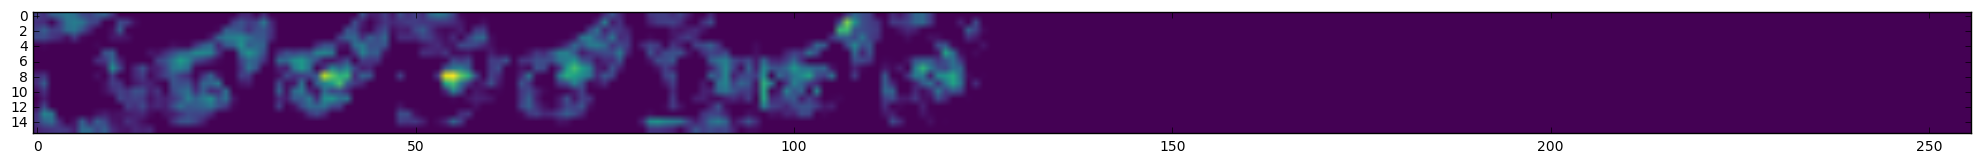

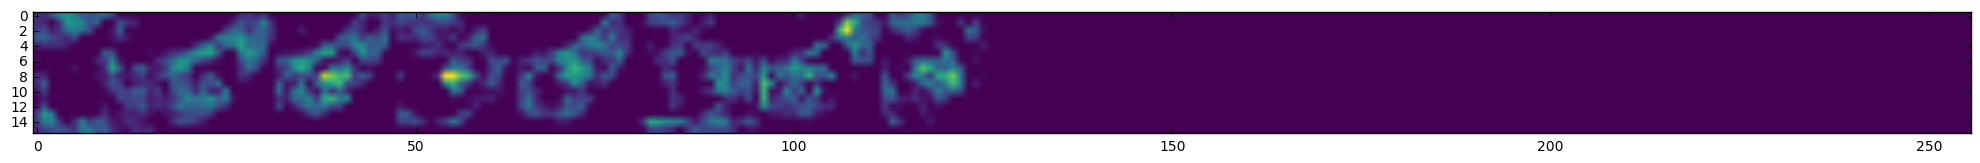

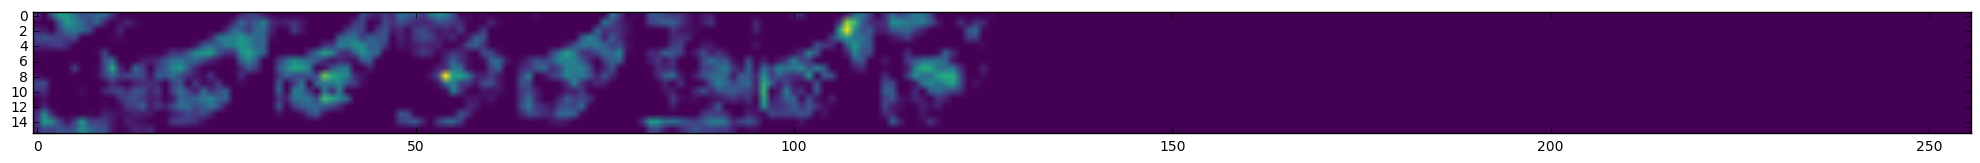

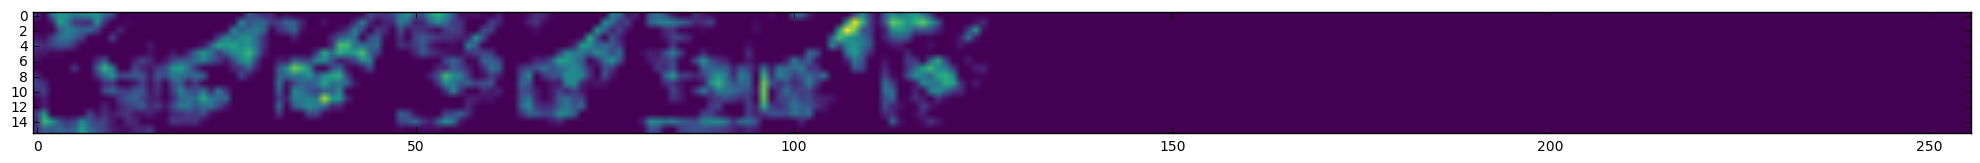

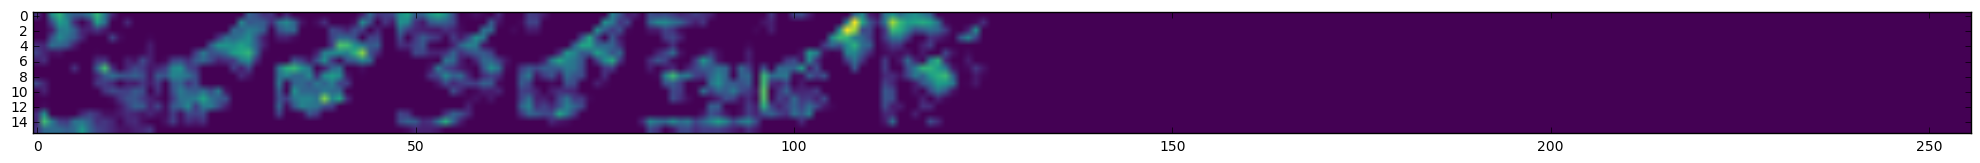

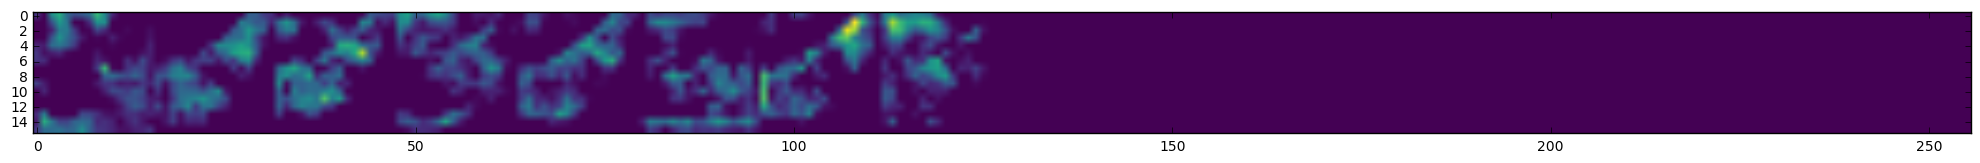

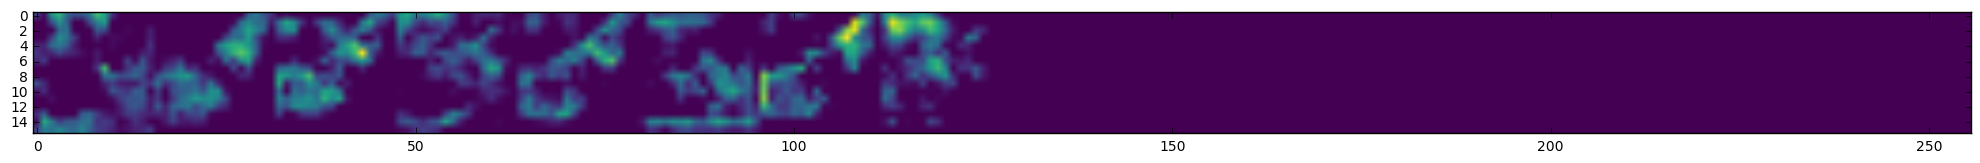

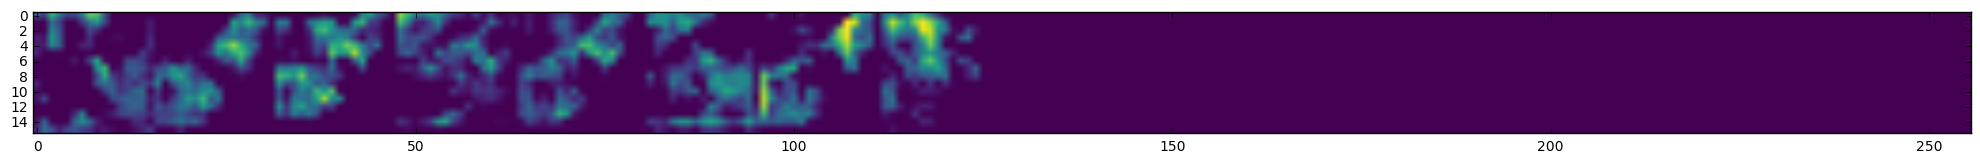

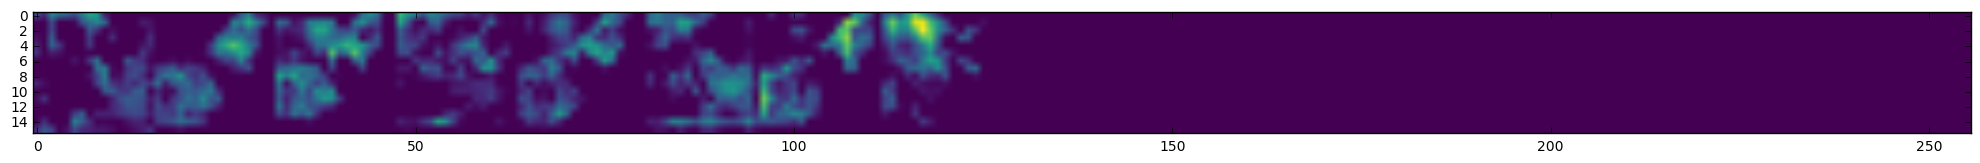

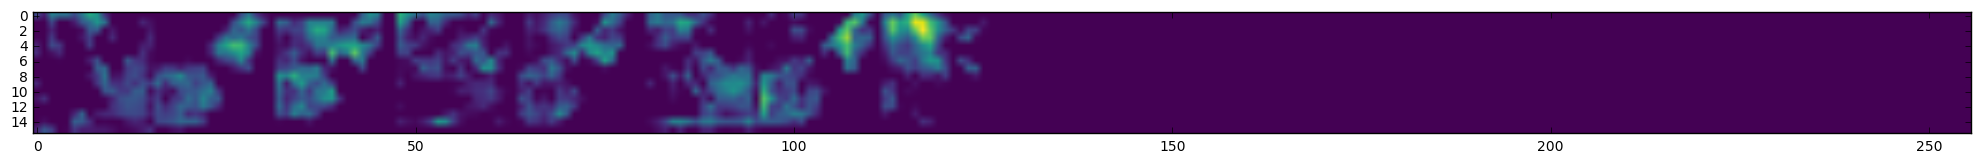

In [38]:
modelsub = Model(inputs=model.input,
                outputs=model.get_layer('activation_66').output)#创建的新模型

activations = modelsub.predict(x_val[2829:2859])#W


for activation in activations:
    # activation = activations[datanum,:,:,:]
    h = activation.shape[0]
    w = activation.shape[1]
    num_channels = activation.shape[2]
    # print(num_channels)
    cols = 16
    rows = math.ceil(num_channels/cols)
    img_grid = np.zeros((h*rows,w*cols))

    for c in range(num_channels):
        f_r = math.ceil((c+1)/cols)
        f_c = (c+1)if f_r==1 else (c+1-(f_r-1)*cols)
        img_grid[(f_r-1)*h:f_r*h,(f_c-1)*w:f_c*w ] = activation[:,:,c]


    plt.figure(figsize=(25,25))
    plt.imshow(img_grid, aspect='equal',cmap='viridis')
    plt.grid(False)
    plt.show()                
